## Set-up

In [88]:
#!pip install scikit-learn
#!pip install bottleneck
#ref: https://github.com/msmbuilder/mdentropy

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline


## Util

In [2]:
from __future__ import print_function

import time
from glob import glob
from itertools import chain

from numpy import (dtype, exp, finfo, float32, isscalar, linspace, log,
                   meshgrid, nan_to_num, pi, random, ravel, unique, void,
                   vstack)
from numpy.linalg import det

from sklearn.neighbors import KernelDensity, NearestNeighbors, BallTree
from scipy.special import digamma, gamma


__all__ = ['floor_threshold', 'parse_files', 'shuffle', 'Timing',
           'unique_row_count', 'kde', 'nearest_distances', 'avgdigamma',
           'volume_unit_ball']
EPS = finfo(float32).eps


class Timing(object):
    "Context manager for printing performance"
    def __init__(self, iteration, verbose=False):
        self.iteration = iteration
        self.start = None
        self.verbose = verbose

    def __enter__(self):
        self.start = time.time()

    def __exit__(self, ty, val, tb):
        end = time.time()
        if self.verbose:
            print("Round %d : %0.3f seconds" %
                  (self.iteration, end - self.start))
        return False


def parse_files(expr):
    expr = expr.replace(' ', '').split(',')
    return list(chain(*map(glob, expr)))


def shuffle(df, n=1):
    """Convenience function for shuffling values in DataFrame objects
    Parameters
    ----------
    df : pandas.DataFrame
        pandas DataFrame
    n : int
        Number of shuffling iterations.
    Returns
    -------
    sdf : array_like, shape = (n_bins, )
        shuffled DataFrame
    """
    sdf = df.copy()
    sampler = random.permutation
    for _ in range(n):
        sdf = sdf.apply(sampler, axis=0)
        sdf = sdf.apply(sampler, axis=1)
    return sdf


def unique_row_count(arr):
    """Convenience function for counting unique rows in a numpy.ndarray
    Parameters
    ----------
    arr : numpy.ndarray
    Returns
    -------
    counts : array_like, shape = (n_bins, )
        unique row counts
    """
    _, counts = unique(arr.view(dtype((void, arr.dtype.itemsize *
                                       arr.shape[1]))), return_counts=True)
    return counts


def floor_threshold(arr, threshold=0.):
    """Convenience funtion for thresholding to a lower bound
    Parameters
    ----------
    arr : numpy.ndarray
    Returns
    -------
    new_arr : numpy.ndarray
        thresholded array
    """
    new_arr = nan_to_num(arr.copy())
    new_arr[arr < threshold] = threshold
    return new_arr


def entropy_gaussian(C):
    '''
    Entropy of a gaussian variable with covariance matrix C
    '''
    if isscalar(C):
        return .5 * (1 + log(2 * pi)) + .5 * log(C)
    else:
        n = C.shape[0]
        return .5 * n * (1 + log(2 * pi)) + .5 * log(abs(det(C)))


def kde(data, rng, grid_size=10,  **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    n_samples = data.shape[0]
    n_dims = data.shape[1]

    bandwidth = (n_samples * (n_dims + 2) / 4.)**(-1. / (n_dims + 4.))
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(data)

    space = [linspace(i[0], i[1], grid_size) for i in rng]
    grid = meshgrid(*tuple(space))

    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(vstack(map(ravel, grid)).T)
    return exp(log_pdf), space


def nearest_distances(X, k=1, leaf_size=16):
    '''
    X = array(N,M)
    N = number of points
    M = number of dimensions
    returns the distance to the kth nearest neighbor for every point in X
    '''
    # small amount of noise to break degeneracy.
    #X += EPS * random.rand(*X.shape)
    X = np.add(X, EPS * random.rand(*X.shape), out=X, casting="unsafe")

    knn = NearestNeighbors(n_neighbors=k + 1, leaf_size=leaf_size,
                           p=float('inf'))
    knn.fit(X)
    d, _ = knn.kneighbors(X)  # the first nearest neighbor is itself
    return d[:, -1]


def avgdigamma(data, dvec, leaf_size=16):
    """Convenience function for finding expectation value of <psi(nx)> given
    some number of neighbors in some radius in a marginal space.
    Parameters
    ----------
    points : numpy.ndarray
    dvec : array_like (n_points,)
    Returns
    -------
    avgdigamma : float
        expectation value of <psi(nx)>
    """
    tree = BallTree(data, leaf_size=leaf_size, p=float('inf'))

    n_points = tree.query_radius(data, dvec - EPS, count_only=True)

    return digamma(n_points).mean()


def volume_unit_ball(n_dims):
    return (pi ** (.5 * n_dims)) / gamma(.5 * n_dims + 1)

## Binning

In [3]:
from numpy import (array, atleast_1d, digitize, empty, floor, linspace, log2,
                   histogramdd, hstack, ndarray, sqrt, vstack)
from scipy.stats import skew

__all__ = ['hist', 'symbolic', 'doanes_rule']


def doanes_rule(x):
    """Convenience function for choosing an optimal number of bins using Doane's Rule.
    Parameters
    ----------
    x : numpy.ndarray or list of floats
        Data to be binned.
    Returns
    -------
    n_bins : int
    """
    if not isinstance(x, ndarray):
        x = array(x)

    n = x.shape[0]
    g1 = atleast_1d(skew(x))
    sg1 = sqrt(6 * (n - 2) / ((n + 1) * (n + 3)))

    return min(floor(1 + log2(n) + log2(1 + abs(g1)/sg1)))


def hist(n_bins, rng, *args):
    """Convenience function for histogramming N-dimentional data
    Parameters
    ----------
    n_bins : int
        Number of bins.
    rng : list of lists
        List of min/max values to bin data over.
    args : array_like, shape = (n_samples, )
        Data of which to histogram.
    Returns
    -------
    bins : array_like, shape = (n_bins, )
    """
    data = vstack((args)).T

    if n_bins is None:
        n_bins = doanes_rule(data)

    return histogramdd(data, bins=n_bins, range=rng)[0].flatten()


def symbolic(n_bins, rng, *args):
    """Symbolic binning of data
    Parameters
    ----------
    rng : list of lists
        List of min/max values for each dimention.
    n_bins : int
        Number of bins to use.
    args : array_like, shape = (n_samples, )
        Data of which to calculate entropy. Each array must have the same
        number of samples.
    Returns
    -------
    counts : float
    """
    labels = empty(0).reshape(args[0].shape[0], 0)
    if n_bins is None:
        n_bins = min(map(doanes_rule, args))

    for i, arg in enumerate(args):

        partitions = linspace(rng[i][0], rng[i][1], n_bins + 1)
        label = digitize(arg, partitions).reshape(-1, 1)

        labels = hstack((labels, label))

    return unique_row_count(labels)

## Calculate Entropy & Conditional Entropy

In [4]:
from itertools import chain

from numpy import ndarray
from numpy import sum as npsum
from numpy import (atleast_2d, arange, bincount, diff, finfo, float32,
                   hsplit, log, nan_to_num, nansum, product, ravel, vstack)

from scipy.stats import entropy as naive
from scipy.special import psi

__all__ = ['entropy', 'centropy']
EPS = finfo(float32).eps


def entropy(n_bins, rng, method, *args):
    """Entropy calculation
    Parameters
    ----------
    n_bins : int
        Number of bins.
    rng : list of lists
        List of min/max values to bin data over.
    method : {'kde', 'chaowangjost', 'grassberger', 'knn', None}
        Method used to calculate entropy.
    args : numpy.ndarray, shape = (n_samples, ) or (n_samples, n_dims)
        Data of which to calculate entropy. Each array must have the same
        number of samples.
    Returns
    -------
    entropy : float
    """
    args = [args] if isinstance(args, ndarray) else args
    args = list(chain(*[map(ravel, hsplit(arg, arg.shape[1]))
                        if arg.ndim == 2
                        else atleast_2d(arg)
                        for arg in args]))

    if method == 'knn':
        return knn_entropy(*args, k=n_bins)

    if rng is None or None in rng:
        rng = len(args) * [None]

    for i, arg in enumerate(args):
        if rng[i] is None:
            rng[i] = (min(arg), max(arg))

    if method == 'kde':
        return kde_entropy(rng, *args, grid_size=n_bins or 20)

    counts = symbolic(n_bins, rng, *args)

    if method == 'chaowangjost':
        return chaowangjost(counts)
    elif method == 'grassberger':
        return grassberger(counts)

    return naive(counts)


def centropy(n_bins, x, y, rng=None, method='knn'):
    """Conditional entropy calculation
    Parameters
    ----------
    n_bins : int
        Number of bins.
    x : array_like, shape = (n_samples, n_dims)
        Conditioned variable.
    y : array_like, shape = (n_samples, n_dims)
        Conditional variable.
    rng : list
        List of min/max values to bin data over.
    method : {'kde', 'chaowangjost', 'grassberger', None}
        Method used to calculate entropy.
    Returns
    -------
    entropy : float
    """
    return (entropy(n_bins, 2 * [rng], method, x, y) -
            entropy(n_bins, [rng], method, y))


def knn_entropy(*args, k=None):
    """Entropy calculation
    Parameters
    ----------
    args : numpy.ndarray, shape = (n_samples, ) or (n_samples, n_dims)
        Data of which to calculate entropy. Each array must have the same
        number of samples.
    k : int
        Number of bins.
    Returns
    -------
    entropy : float
    """
    data = vstack((args)).T
    n_samples, n_dims = data.shape
    k = k if k else max(3, int(n_samples * 0.01))

    nneighbor = nearest_distances(data, k=k)
    const = psi(n_samples) - psi(k) + n_dims * log(2.)

    return (const + n_dims * log(nneighbor).mean())


def kde_entropy(rng, *args, grid_size=20, **kwargs):
    """Kernel Density Estimation of Entropy"""
    data = vstack((args)).T

    prob, space = kde(data, rng, grid_size=20, **kwargs)

    return -nansum(prob * log(prob)) * product(diff(space)[:, 0])


def grassberger(counts):
    """Entropy calculation using Grassberger correction.
    doi:10.1016/0375-9601(88)90193-4
    Parameters
    ----------
    counts : list
        bin counts
    Returns
    -------
    entropy : float
    """
    n_samples = npsum(counts)
    return npsum(counts * (log(n_samples) -
                           nan_to_num(psi(counts)) -
                           ((-1.) ** counts / (counts + 1.)))) / n_samples


def chaowangjost(counts):
    """Entropy calculation using Chao, Wang, Jost correction.
    doi: 10.1111/2041-210X.12108
    Parameters
    ----------
    counts : list
        bin counts
    Returns
    -------
    entropy : float
    """
    n_samples = npsum(counts)
    bcbc = bincount(counts.astype(int))
    if len(bcbc) < 3:
        return grassberger(counts)
    if bcbc[2] == 0:
        if bcbc[1] == 0:
            A = 1.
        else:
            A = 2. / ((n_samples - 1.) * (bcbc[1] - 1.) + 2.)
    else:
        A = 2. * bcbc[2] / ((n_samples - 1.) * (bcbc[1] - 1.) +
                            2. * bcbc[2])
    pr = arange(1, int(n_samples))
    pr = 1. / pr * (1. - A) ** pr
    entropy = npsum(counts / n_samples * (psi(n_samples) -
                    nan_to_num(psi(counts))))

    if bcbc[1] > 0 and A != 1.:
        entropy += nan_to_num(bcbc[1] / n_samples *
                              (1 - A) ** (1 - n_samples *
                                          (-log(A) - npsum(pr))))
    return entropy

## Calculate MI & CMI

In [5]:
from numpy import (atleast_2d, diff, finfo, float32, hstack, nan_to_num, sqrt)

from scipy.special import psi

__all__ = ['mutinf', 'nmutinf', 'cmutinf', 'ncmutinf']
EPS = finfo(float32).eps


def mutinf(n_bins, x, y, rng=None, method='knn'):
    """Mutual information calculation
    Parameters
    ----------
    n_bins : int
        Number of bins.
    x : array_like, shape = (n_samples, n_dim)
        Independent variable
    y : array_like, shape = (n_samples, n_dim)
        Independent variable
    rng : list
        List of min/max values to bin data over.
    method : {'kde', 'chaowangjost', 'grassberger', 'knn', None}
        Method used to calculate entropy.
    Returns
    -------
    entropy : float
    """
    if method == 'knn':
        return knn_mutinf(x, y, k=n_bins,
                          boxsize=diff(rng).max() if rng else None)

    return (entropy(n_bins, [rng], method, x) +
            entropy(n_bins, [rng], method, y) -
            entropy(n_bins, 2 * [rng], method, x, y))


def knn_mutinf(x, y, k=None, boxsize=None):
    """k-NN mutual information calculation
    Parameters
    ----------
    x : array_like, shape = (n_samples, n_dim)
        Independent variable
    y : array_like, shape = (n_samples, n_dim)
        Independent variable
    k : int
        Number of bins.
    boxsize : float (or None)
        Wrap space between [0., boxsize)
    Returns
    -------
    mi : float
    """
    data = hstack((x, y))

    k = k if k else max(3, int(data.shape[0] * 0.01))

    # Find nearest neighbors in joint space, p=inf means max-norm
    dvec = nearest_distances(data, k=k)
    a, b, c, d = (avgdigamma(atleast_2d(x).reshape(data.shape[0], -1), dvec),
                  avgdigamma(atleast_2d(y).reshape(data.shape[0], -1), dvec),
                  psi(k), psi(data.shape[0]))
    return max((-a - b + c + d), 0.)


def nmutinf(n_bins, x, y, rng=None, method='knn'):
    """Normalized mutual information calculation
    Parameters
    ----------
    n_bins : int
        Number of bins.
    x : array_like, shape = (n_samples, n_dim)
        Independent variable
    y : array_like, shape = (n_samples, n_dim)
        Independent variable
    rng : list
        List of min/max values to bin data over.
    method : {'kde', 'chaowangjost', 'grassberger', 'knn', None}
        Method used to calculate entropy.
    Returns
    -------
    entropy : float
    """
    return nan_to_num(mutinf(n_bins, x, y, method=method, rng=rng) /
                      sqrt(entropy(n_bins, [rng], method, x) *
                      entropy(n_bins, [rng], method, y)))


def cmutinf(n_bins, x, y, z, rng=None, method='knn'):
    """Conditional mutual information calculation
    Parameters
    ----------
    n_bins : int
        Number of bins.
    x : array_like, shape = (n_samples, n_dim)
        Conditioned variable
    y : array_like, shape = (n_samples, n_dim)
        Conditioned variable
    z : array_like, shape = (n_samples, n_dim)
        Conditional variable
    rng : list
        List of min/max values to bin data over.
    method : {'kde', 'chaowangjost', 'grassberger', 'knn', None}
        Method used to calculate entropy.
    Returns
    -------
    entropy : float
    """
    if method == 'knn':
        return knn_cmutinf(x, y, z, k=n_bins,
                           boxsize=diff(rng).max() if rng else None)

    return (centropy(n_bins, x, z, rng=rng, method=method) +
            entropy(n_bins, 2 * [rng], method, y, z) -
            entropy(n_bins, 3 * [rng], method, x, y, z))


def knn_cmutinf(x, y, z, k=None, boxsize=None):
    """Entropy calculation
    Parameters
    ----------
    x : array_like, shape = (n_samples, n_dim)
        Conditioned variable
    y : array_like, shape = (n_samples, n_dim)
        Conditioned variable
    z : array_like, shape = (n_samples, n_dim)
        Conditional variable
    k : int
        Number of bins.
    boxsize : float (or None)
        Wrap space between [0., boxsize)
    Returns
    -------
    cmi : float
    """
    data = hstack((x, y, z))

    k = k if k else max(3, int(data.shape[0] * 0.01))

    # Find nearest neighbors in joint space, p=inf means max-norm
    dvec = nearest_distances(data, k=k)
    a, b, c, d = (avgdigamma(hstack((x, z)), dvec),
                  avgdigamma(hstack((y, z)), dvec),
                  avgdigamma(atleast_2d(z).reshape(data.shape[0], -1), dvec),
                  psi(k))
    return max((-a - b + c + d), 0.)


def ncmutinf(n_bins, x, y, z, rng=None, method='knn'):
    """Normalized conditional mutual information calculation
    Parameters
    ----------
    n_bins : int
        Number of bins.
    x : array_like, shape = (n_samples, n_dim)
        Conditioned variable
    y : array_like, shape = (n_samples, n_dim)
        Conditioned variable
    z : array_like, shape = (n_samples, n_dim)
        Conditional variable
    rng : list
        List of min/max values to bin data over.
    method : {'kde', 'chaowangjost', 'grassberger', 'knn', None}
        Method used to calculate entropy.
    Returns
    -------
    ncmi : float
    """
    return (cmutinf(n_bins, x, y, z, rng=rng, method=method) /
            centropy(n_bins, x, z, rng=rng, method=method))

## Read data

In [6]:
#df = pd.read_csv("./NSDUH_2015_Tab.tsv", sep="\t")
import fastparquet
df = pd.read_parquet("df_clean_mean_onemeta.parquet")

In [7]:
df.head()

,QUESTID2,FILEDATE,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,CADRKHERN2_NA,CADRKHALL2_NA,CADRKINHL2_NA,CADRKMETH2_NA,GQTYPE2_NA,HEALTH2_NA,COLLENRFT_NA,COLLENRST_NA,NRCH17_2_NA,POVERTY3_NA
0,25095143,02/15/2018,1,3.841657,3.877784,16.000000,2014.000000,1.000000,2.000000,20.954509,...,0,0,0,0,0,0,0,0,0,0
1,13005143,02/15/2018,1,3.841657,3.877784,15.000000,2014.163743,6.397476,3.000000,20.954509,...,0,0,0,0,1,0,0,0,0,0
2,67415143,02/15/2018,2,3.841657,3.877784,15.774274,2014.163743,6.397476,2.684538,20.954509,...,0,0,0,0,1,0,0,0,0,0
3,70925143,02/15/2018,2,3.000000,4.000000,15.774274,2014.163743,6.397476,2.684538,20.954509,...,0,0,0,0,1,0,0,0,0,0
4,75235143,02/15/2018,1,3.841657,3.877784,17.000000,2014.163743,6.397476,1.000000,22.000000,...,0,0,0,0,1,0,0,0,0,0


In [8]:
np.shape(df)

(57146, 4743)

In [9]:
missing = df.columns[df.isna().any()].tolist()
df = df.drop(columns=missing)

## Test out MI & CMI calculation

In [312]:
#wrap in function
from sklearn import feature_selection
import numpy as np

def itermi(y, x, n): #n should be at least 2
    global itmu, features, scores
    y_array = y.values
    x_array = x.values
    mi = feature_selection.mutual_info_classif(x,y,random_state=123) #use SKlearn built-in function to compute pair-wise MI
    idx = np.argmax(mi) #find the max MI variable
    scores.append(np.max(mi))
    itmu.append(x.columns[idx]) #store the name of max MI variable 
    z_array = x_array[:,idx] #select the max MI variable out
    z_array = z_array[:, None]
    del features[idx]
    x_array = np.delete(x_array,idx,1)
    cmi(y, x_array, z_array, n) #use the recursive conditional MI function below
    return itmu, scores

def cmi(y, x_array, z_array, n): 
    if n == 1: return itmu, scores  #recursion until done
    cmu = [] #store the conditional MI values in each round
    for i in range(np.shape(x_array)[1]):
        cmu_value = cmutinf(doanes_rule(x_array[:,[i]]), x_array[:,[i]], y, z_array, rng=None, method=None)
        cmu.append(cmu_value)
    idx = np.argmax(cmu)
    scores.append(np.max(cmu))
    itmu.append(features[idx]) #store the name of max MI variable
    z_new = x_array[:,idx]#select the max MI variable out
    z_new = z_new[:, None] #make it into 2d array to match the dimension
    print(np.shape(z_new), np.shape(z_array))
    z_array = np.append(z_array, z_new, axis=1)
    del features[idx]
    x_array = np.delete(x_array,idx,1)
    cmi(y, x_array, z_array, n-1)

In [275]:
features = x.columns.tolist() #store the features
itmu = [] #store the top MI variables (the first one is from univariate MI, the ones following are from conditional MI)
scores = []
ds = df.loc[:,['OPINMYR','TXYRNDILAL','TXALCONLY','TXYRNDILL']]
y = ds['OPINMYR']
x = ds.drop(['OPINMYR'], 1)
itm, score = itermi(y, x, 2)


/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [276]:
itm

['TXYRNDILAL', 'TXYRNDILL']

In [277]:
score

[0.03034220694549994, 0.004975538015684511]

### Downsample for a subset of data to evaluate

In [167]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df.UDPYOPI==0]
df_minority = df[df.UDPYOPI==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=603,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.UDPYOPI.value_counts()

1    603
0    603
Name: UDPYOPI, dtype: int64

In [168]:
y_d = df_downsampled.loc[:,'UDPYOPI']
X_d = df_downsampled.drop(['QUESTID2','UDPYOPI','FILEDATE','ANALWT_C','VESTR','VEREP'], 1)


### Seperate all variables into different categories according to codebook, and run JMI

- SELF-ADMINISTERED SUBSTANCE USE SECTIONS: SASUS
- IMPUTED SUBSTANCE USE: ISU
- OTHER SELF-ADMINISTERED SECTIONS : OSAS
- INTERVIEW INFORMATION: II
- DEMOGRAPHICS: DEMO
- GEOGRAPHIC: GEO
- (omit identification, FI debriefing questions and sample weights section)

In [169]:
SASUS = X_d.loc[:,'CIGEVER':'SEDNORXFG']
ISU = X_d.loc[:,'IRCIGRC':'PNRNMWUD']
OSAS = X_d.loc[:,'COLDMEDS':'CADRKMETH2']
II = X_d.loc[:,'LANGVER':'AGE2']
DEMO = X_d.loc[:,'SERVICE':'POVERTY3']
GEO = X_d.loc[:,'PDEN10':'AIIND102']

In [173]:
GEO.head()

,PDEN10,COUTYP4,MAIIN102,AIIND102
5006,1,1,2,2
46814,2,2,2,2
43133,1,1,2,2
28980,2,2,2,2
50925,2,3,2,2


In [299]:
features = SASUS.columns.tolist() #store the features
itmu = [] #store the top MI variables (the first one is from univariate MI, the ones following are from conditional MI)
scores = []
y_d = df_downsampled.loc[:,'UDPYOPI']
itermi(y_d, SASUS, 2)

/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(['PNRNMREC', 'PNRNM30D'], [0.5499929313475751, 0.3558004089532347])

In [261]:
feature_selection.mutual_info_classif(x_d,y_d, random_state=123)

array([0.0004056 , 0.00626835, 0.        , 0.01623784])

In [259]:
itmu

['AIIND102', 'COUTYP4']

In [260]:
scores

[0.016237839903977758, 0.003525224008809502]

In [313]:
y_d = df_downsampled.loc[:,'UDPYOPI']
fealist = []
miscore = []
for df in [SASUS,ISU,OSAS,II,DEMO,GEO]:
    n = min([len(df.columns)-2, 5]) #get the right number of features to subset with for each category
    print(n)
    features = df.columns.tolist() #store the features
    itmu = [] #store the top MI variables (the first one is from univariate MI, the ones following are from conditional MI)
    scores = []
    x_d = df
    itm, score = itermi(y_d, x_d, n)
    fealist.append(itm)
    miscore.append(score)

5


/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(1206, 1) (1206, 1)
(1206, 1) (1206, 2)
(1206, 1) (1206, 3)
(1206, 1) (1206, 4)
5


/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(1206, 1) (1206, 1)
(1206, 1) (1206, 2)
(1206, 1) (1206, 3)
(1206, 1) (1206, 4)
5


/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(1206, 1) (1206, 1)
(1206, 1) (1206, 2)
(1206, 1) (1206, 3)
(1206, 1) (1206, 4)
1
5


/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


(1206, 1) (1206, 1)
(1206, 1) (1206, 2)
(1206, 1) (1206, 3)
(1206, 1) (1206, 4)
2
(1206, 1) (1206, 1)


/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [314]:
fealist

[['PNRNMREC', 'PNRNM30D', 'PNRNMLIF', 'HERREC', 'ALCDAYS'],
 ['HERPNRYR', 'PNRNMWUD', 'IRHERYFU', 'IRCRKRC', 'SRCCLFRTRQ'],
 ['UDPYHRPNR', 'RSKMRJWK', 'DEPENDSED', 'ALCLIMIT', 'RSKYFQDGR'],
 ['AGE2'],
 ['WRKSTATWK2', 'IREDUHIGHST2', 'SEXRACE', 'IRFAMIN3', 'IRHHSIZ2'],
 ['AIIND102', 'COUTYP4']]

In [315]:
miscore

[[0.5499929313475751,
  0.3558004089532347,
  0.35492466022776714,
  0.06615952474425502,
  0.022419668810333526],
 [0.6104199172393558,
  0.05328048916614625,
  0.023868454639461634,
  0.0022989956237480236,
  0.0015833685778483542],
 [0.6935619461459944,
  4.440892098500626e-16,
  1.3322676295501878e-15,
  1.3322676295501878e-15,
  8.881784197001252e-16],
 [0.04905500871586432],
 [0.05326625678600849,
  0.05753225424593822,
  0.15245341048263672,
  0.21690873237328923,
  0.1323114701204524],
 [0.016237839903977758, 0.003525224008809502]]

In [327]:
import itertools
chainfea = list(itertools.chain(*fealist))
chainscr = list(itertools.chain(*miscore))

In [328]:
result = pd.DataFrame(
    {'Category': ['SASUS']*5 +['ISU']*5 + ['OSAS']*5 + ['II']*1 + ['DEMO']*5 + ['GEO']*2,
     'Features': chainfea,
     'MI_value': chainscr
    })

In [329]:
result

,Category,Features,MI_value
0,SASUS,PNRNMREC,5.499929e-01
1,SASUS,PNRNM30D,3.558004e-01
2,SASUS,PNRNMLIF,3.549247e-01
3,SASUS,HERREC,6.615952e-02
4,SASUS,ALCDAYS,2.241967e-02
5,ISU,HERPNRYR,6.104199e-01
6,ISU,PNRNMWUD,5.328049e-02
7,ISU,IRHERYFU,2.386845e-02
8,ISU,IRCRKRC,2.298996e-03
9,ISU,SRCCLFRTRQ,1.583369e-03


In [330]:
result.to_csv('MIfeatures.csv')

## Clustering based on selected features

### Data preprocessing

In [354]:
np.shape(y_d)

(1206,)

In [347]:
xr = df_downsampled.loc[:, chainfea] #subset 23 most relevant features
np.shape(xr)

(1206, 23)

### K-means clustering

In [372]:
from sklearn.decomposition import PCA
pca = PCA(3) #capture >70% of variance, good PCA result
pca.fit(xr) 
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.30296198 0.197088   0.18730295]
[202.8302565  163.59452511 159.48174639]


In [373]:
# Turn data into three columns with PCA
xr_pca = pca.fit_transform(xr)

In [368]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(xr_pca)

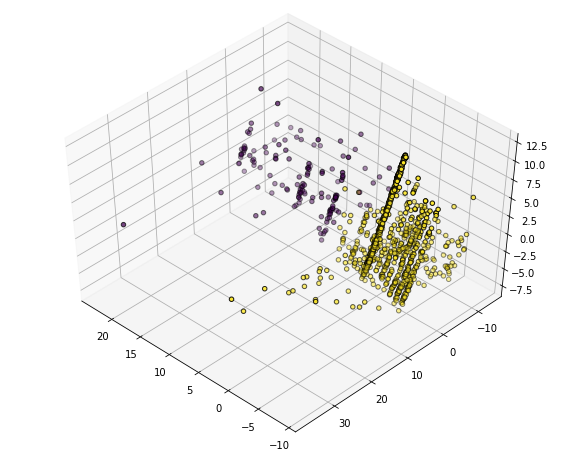

In [382]:
#plot the clusters
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = kmeans.labels_
ax.scatter(xr_pca[:,0], xr_pca[:,1], xr_pca[:,2],
           c=labels.astype(np.float), edgecolor='k')


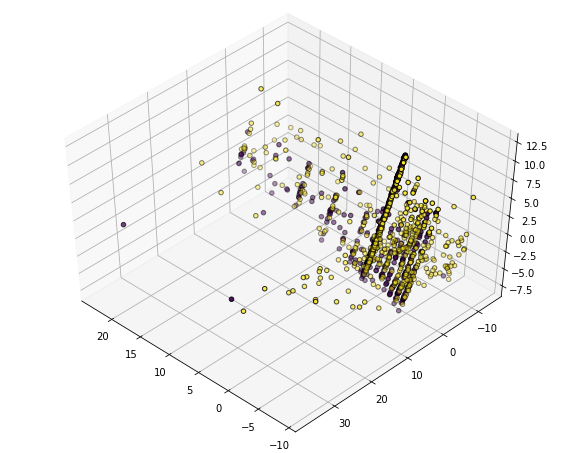

In [378]:
# Plot the ground truth
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# Reorder the labels to have colors matching the cluster results
y_d = y_d.astype(np.float)
ax.scatter(xr_pca[:,0], xr_pca[:,1], xr_pca[:,2],
           c=y_d, edgecolor='k')

### Spectral Clustering

In [379]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=2,random_state=0).fit(xr_pca)

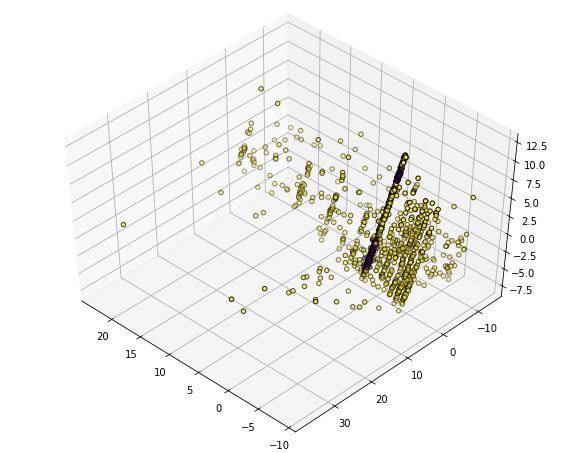

In [383]:
#plot the predicted class
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = clustering.labels_
# Reorder the labels to have colors matching the cluster results
lab = np.choose(labels, [1, 0]).astype(np.float)
ax.scatter(xr_pca[:,0], xr_pca[:,1], xr_pca[:,2],
           c=lab, edgecolor='k')


### Hierarchical Clustering

/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


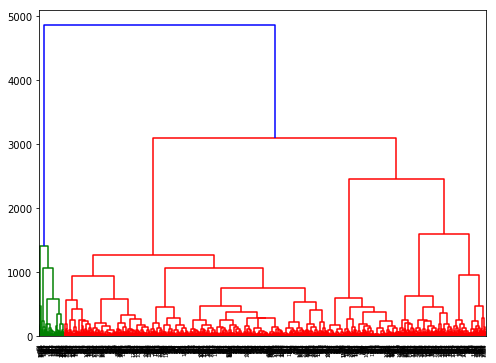

In [387]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
x_d  = euclidean_distances(xr.values)
Z = linkage(x_d, 'ward')
fig = plt.figure(figsize=(8, 6))
dn = dendrogram(Z)

- 2 clusters suggested from Dendrogram (same for all 3 clustering methods)
- if we want to run models within each segment, then each segment should have a good mix of class = 0 & 1 ?
    - if so, the clustering output which doesn't fit exactly with the true class label might actually be beneficial?